# Prepare Data

In [1]:
import json
with open('/content/drive/MyDrive/colab/kaggle.json', 'r') as f:
    kaggle_json = json.load(f)
with open('kaggle.json', 'w') as j:
    json.dump(kaggle_json, j) 
!ls -1ha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

kaggle.json


In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:11<00:00, 76.0MB/s]
100% 2.29G/2.29G [00:11<00:00, 222MB/s] 


In [ ]:
!unzip /content/chest-xray-pneumonia.zip

In [269]:
# tpu ready
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
#warnings.filterwarnings(action='ignore')
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)
#strategy = tf.distribute.experimental.TPUStrategy(tpu)
#BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [7]:
import os
print(len(os.listdir('/content/chest_xray/train/NORMAL')))
print(len(os.listdir('/content/chest_xray/chest_xray/train/NORMAL')))
print(len(os.listdir('/content/chest_xray/__MACOSX/chest_xray/train/NORMAL')))


1341
1342
1342


In [17]:
is_duplicated = {}
for i in os.listdir('/content/chest_xray/chest_xray/train/NORMAL'):

    if i in os.listdir('/content/chest_xray/train/NORMAL'):
        is_duplicated[i] = True
    else:
        is_duplicated[i] = False

## duplicated data remove

In [ ]:
sum(is_duplicated.values())

In [291]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [720,720]
ROOT_PATH = '/content/chest_xray'
TRAIN_PATH = ROOT_PATH + '/train/*/*.jpeg'
VAL_PATH = ROOT_PATH + '/val/*/*.jpeg'
TEST_PATH = ROOT_PATH + '/test/*/*.jpeg'
EPOCHS = 25

In [292]:
train_files = tf.io.gfile.glob(TRAIN_PATH)
test_files = tf.io.gfile.glob(TEST_PATH)
val_files = tf.io.gfile.glob(VAL_PATH)
print(len(train_files),len(test_files),len(val_files))

5216 624 16


In [293]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

In [294]:
filenames[:10]

['/content/chest_xray/train/NORMAL/NORMAL2-IM-0882-0001.jpeg',
 '/content/chest_xray/train/NORMAL/NORMAL2-IM-0930-0001.jpeg',
 '/content/chest_xray/train/NORMAL/NORMAL2-IM-0521-0001.jpeg',
 '/content/chest_xray/train/NORMAL/NORMAL2-IM-1301-0001.jpeg',
 '/content/chest_xray/train/NORMAL/NORMAL2-IM-1045-0001.jpeg',
 '/content/chest_xray/train/NORMAL/NORMAL2-IM-1112-0001.jpeg',
 '/content/chest_xray/train/NORMAL/IM-0362-0001.jpeg',
 '/content/chest_xray/train/NORMAL/NORMAL2-IM-1294-0001-0001.jpeg',
 '/content/chest_xray/train/NORMAL/IM-0697-0001.jpeg',
 '/content/chest_xray/train/NORMAL/NORMAL2-IM-0522-0001.jpeg']

## train, val split(ratio balance)

In [295]:
def get_label(file_path):
    parts = tf.strings.split(file_path,os.path.sep) # path를 '/' 기준 split
    return parts[-2] == "PNEUMONIA"
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) #이미지 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE만큼 수정
    return img
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path) # 이미지 읽기
    #with open(file_path, 'rb') as f:
    #    img = f.read() # get label
    img = decode_img(img) # image preprocess
    return img, label

In [296]:
train_size = int((len(filenames)*0.8))
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]
print(len(train_filenames),len(val_filenames))

4185 1047


In [297]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1111
Pneumonia images count in training set: 3074


In [298]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
images = {}
for i,path in enumerate(train_filenames):
    with open(path,'rb') as f:
        img = f.read()
        images[i] = img
labels = {}
for i,path in enumerate(train_filenames):
    parts = tf.strings.split(path,os.path.sep)
    labels[i] = parts[-2] == "PNEUMONIA"

In [299]:
#file count
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(TRAIN_IMG_COUNT)
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(VAL_IMG_COUNT)

4185
1047


In [300]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [301]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (720, 720, 3)
Label:  False


In [302]:
BATCH_SIZE = 16

In [303]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
print(TEST_IMAGE_COUNT)

624


In [304]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

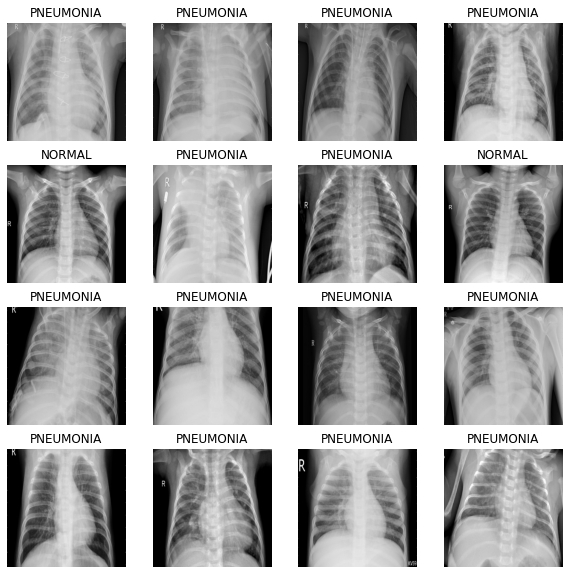

In [305]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [306]:
def conv_block(filters):
    block = tf.keras.Sequential([
                tf.keras.layers.SeparableConv2D(filters, 3, activation='relu',padding='same'),
                tf.keras.layers.SeparableConv2D(filters, 3, activation='relu',padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPool2D()
    ])
    return block

In [307]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
                    tf.keras.layers.Dense(units, activation='relu'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

Batch Normalization과 Dropout을 동시에 쓰는 것에 대한 글  
[Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)  
[Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks](https://arxiv.org/pdf/1905.05928.pdf)

In [308]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        dense_block(512,0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

## Data imbalance process

[클래스가 불균형 할때 참조글](https://3months.tistory.com/414)

In [309]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.88
Weight for PNEUMONIA: 0.68


## First try(basic) batch 16

In [98]:
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),

    conv_block(32),
    conv_block(64),
    conv_block(128),
    tf.keras.layers.Dropout(0.2),
    conv_block(256),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    dense_block(512,0.7),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
#call back function
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
261/261 [==============================] - 50s 159ms/step - loss: 0.4134 - accuracy: 0.8096 - precision: 0.9509 - recall: 0.7847 - val_loss: 0.6526 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 41s 157ms/step - loss: 0.2715 - accuracy: 0.8992 - precision: 0.9706 - recall: 0.8916 - val_loss: 1.0388 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 41s 158ms/step - loss: 0.2222 - accuracy: 0.9179 - precision: 0.9730 - recall: 0.9151 - val_loss: 0.7216 - val_accuracy: 0.7413 - val_precision: 0.7393 - val_recall: 1.0000


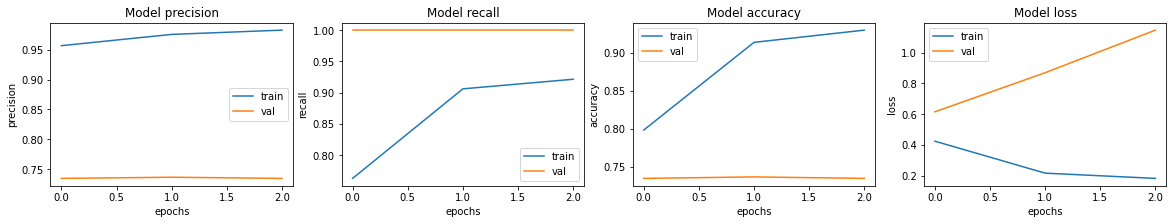

In [59]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Second try (batch = 32)

In [99]:
BATCH_SIZE = 32
tf.keras.backend.clear_session()
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
#call back function
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
130/130 [==============================] - 33s 186ms/step - loss: 0.5336 - accuracy: 0.7159 - precision: 0.9177 - recall: 0.6756 - val_loss: 0.5927 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 2/5
130/130 [==============================] - 23s 179ms/step - loss: 0.2922 - accuracy: 0.8726 - precision: 0.9696 - recall: 0.8573 - val_loss: 0.7243 - val_accuracy: 0.7207 - val_precision: 0.7207 - val_recall: 1.0000
Epoch 3/5
130/130 [==============================] - 23s 181ms/step - loss: 0.2330 - accuracy: 0.9077 - precision: 0.9736 - recall: 0.9010 - val_loss: 0.8989 - val_accuracy: 0.7480 - val_precision: 0.7480 - val_recall: 1.0000


In [100]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 102ms/step - loss: 1.3243 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.3243000507354736,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


# Third try (batch = 64)

In [101]:
BATCH_SIZE = 64
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),

    conv_block(32),
    conv_block(64),
    conv_block(128),
    tf.keras.layers.Dropout(0.2),
    conv_block(256),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    dense_block(512,0.7),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
#call back function
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
65/65 [==============================] - 26s 257ms/step - loss: 0.5941 - accuracy: 0.6904 - precision: 0.9000 - recall: 0.6545 - val_loss: 0.6523 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 2/5
65/65 [==============================] - 15s 231ms/step - loss: 0.3694 - accuracy: 0.8163 - precision: 0.9486 - recall: 0.7940 - val_loss: 0.5456 - val_accuracy: 0.7656 - val_precision: 0.7656 - val_recall: 1.0000
Epoch 3/5
65/65 [==============================] - 15s 229ms/step - loss: 0.2958 - accuracy: 0.8635 - precision: 0.9732 - recall: 0.8404 - val_loss: 0.6656 - val_accuracy: 0.7188 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 4/5
65/65 [==============================] - 15s 234ms/step - loss: 0.3032 - accuracy: 0.8885 - precision: 0.9743 - recall: 0.8745 - val_loss: 0.7391 - val_accuracy: 0.7227 - val_precision: 0.7227 - val_recall: 1.0000


In [102]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 103ms/step - loss: 0.9666 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.9666348695755005,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


# DATA Augmentation

In [244]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def up_down_augment(image,label):
    image = tf.image.random_flip_up_down(image)
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds
shuffle_buffer_size=1000
BATCH_SIZE = 32
LR_train_ds = train_ds.map(augment, num_parallel_calls=2)
# LR_train_ds = LR_train_ds.shuffle(buffer_size=shuffle_buffer_size)
# LR_train_ds = LR_train_ds.repeat()
# LR_train_ds = LR_train_ds.batch(BATCH_SIZE)
# LR_train_ds = LR_train_ds.prefetch(buffer_size=AUTOTUNE)
LR_val_ds = val_ds.map(augment, num_parallel_calls=2)
# LR_val_ds = LR_val_ds.shuffle(buffer_size=shuffle_buffer_size)
# LR_val_ds = LR_val_ds.repeat()
# LR_val_ds = LR_val_ds.batch(BATCH_SIZE)
# LR_val_ds = LR_val_ds.prefetch(buffer_size=AUTOTUNE)

In [243]:
LR_train_ds

<ParallelMapDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

In [245]:
def up_down_augment(image,label):
    image = tf.image.random_flip_up_down(image)
    return image,label

def up_down_prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            up_down_augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds
UD_train_ds = train_ds.map(up_down_augment, num_parallel_calls=2)
# UD_train_ds = UD_train_ds.shuffle(buffer_size=shuffle_buffer_size)
# UD_train_ds = UD_train_ds.repeat()
# UD_train_ds = UD_train_ds.batch(BATCH_SIZE)
# UD_train_ds = UD_train_ds.prefetch(buffer_size=AUTOTUNE)
UD_val_ds = train_ds.map(up_down_augment, num_parallel_calls=2)
# UD_val_ds = UD_val_ds.shuffle(buffer_size=shuffle_buffer_size)
# UD_val_ds = UD_val_ds.repeat()
# UD_val_ds = UD_val_ds.batch(BATCH_SIZE)
# UD_val_ds = UD_val_ds.prefetch(buffer_size=AUTOTUNE)

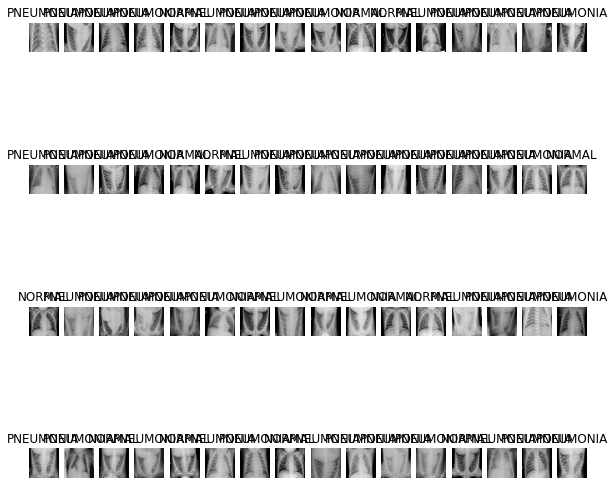

In [172]:
image_batch, label_batch = next(iter(UD_train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

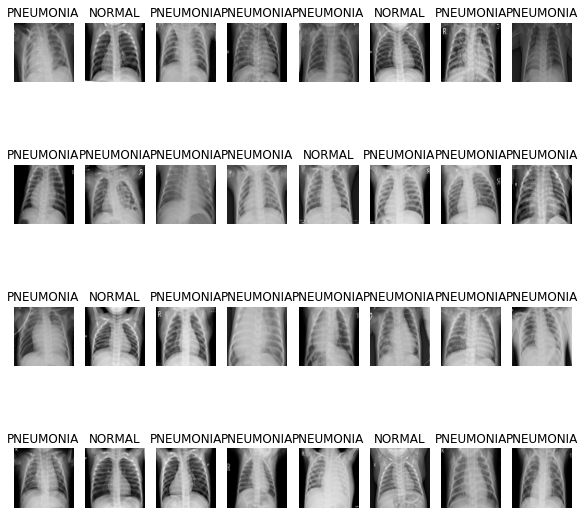

In [199]:
image_batch, label_batch = next(iter(LR_train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Fourth Data BATCH = 32, No dropout

In [247]:
triple_ds = train_ds.concatenate(LR_train_ds).concatenate(UD_train_ds)
triple_val_ds = val_ds.concatenate(LR_val_ds).concatenate(UD_val_ds)

In [249]:
triple_val_ds

<ConcatenateDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

In [195]:
triple_ds = triple_ds.shuffle(buffer_size=1000)
triple_ds = triple_ds.repeat()
triple_ds = triple_ds.batch(BATCH_SIZE)
triple_ds = triple_ds.prefetch(buffer_size=AUTOTUNE)

In [175]:
triple_val_ds = triple_val_ds.shuffle(buffer_size=1000)
triple_val_ds = triple_val_ds.repeat()
triple_val_ds = triple_val_ds.batch(BATCH_SIZE)
triple_val_ds = triple_val_ds.prefetch(buffer_size=AUTOTUNE)

In [233]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [246]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

In [235]:
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),
    conv_block(32),
    conv_block(64),
    conv_block(128),
    #tf.keras.layers.Dropout(0.2),
    conv_block(256),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    dense_block(512,0.7),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
   ])

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    #call back function
    es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
130/130 [==============================] - 66s 428ms/step - loss: 0.2961 - accuracy: 0.8700 - precision: 0.9733 - recall: 0.8486 - val_loss: 0.5843 - val_accuracy: 0.7295 - val_precision: 0.7295 - val_recall: 1.0000
Epoch 2/5
130/130 [==============================] - 53s 407ms/step - loss: 0.1755 - accuracy: 0.9349 - precision: 0.9780 - recall: 0.9335 - val_loss: 0.7098 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/5
130/130 [==============================] - 52s 405ms/step - loss: 0.1370 - accuracy: 0.9500 - precision: 0.9843 - recall: 0.9481 - val_loss: 1.0493 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000


In [146]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 103ms/step - loss: 1.3068 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.3068273067474365,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


## Fifth Data BATCH = 32, No dropout, Dense block(256)added triple augmented data

In [238]:
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),
    conv_block(32),
    conv_block(64),
    conv_block(128),
    #tf.keras.layers.Dropout(0.2),
    conv_block(256),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    dense_block(512,0.7),
    dense_block(256,0.7), # added
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
   ])

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    #call back function
    es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
    history = model.fit(
        triple_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
130/130 [==============================] - 67s 422ms/step - loss: 0.4853 - accuracy: 0.7284 - precision: 0.9319 - recall: 0.6851 - val_loss: 0.5829 - val_accuracy: 0.7305 - val_precision: 0.7305 - val_recall: 1.0000
Epoch 2/5
130/130 [==============================] - 53s 407ms/step - loss: 0.2190 - accuracy: 0.9106 - precision: 0.9769 - recall: 0.9010 - val_loss: 0.8940 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/5
130/130 [==============================] - 53s 407ms/step - loss: 0.1795 - accuracy: 0.9310 - precision: 0.9776 - recall: 0.9287 - val_loss: 0.9708 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000


In [239]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 103ms/step - loss: 1.3698 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.3698047399520874,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


In [250]:
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),
    conv_block(32),
    conv_block(64),
    conv_block(128),
    #tf.keras.layers.Dropout(0.2),
    conv_block(256),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    dense_block(512,0.7),
    dense_block(256,0.7), # added
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
   ])

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    #call back function
    es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
    history = model.fit(
        triple_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        callbacks=[es],
        validation_data=triple_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    

Epoch 1/5
130/130 [==============================] - 65s 416ms/step - loss: 0.4292 - accuracy: 0.8005 - precision: 0.9405 - recall: 0.7813 - val_loss: 0.6636 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/5
130/130 [==============================] - 52s 405ms/step - loss: 0.2108 - accuracy: 0.9185 - precision: 0.9759 - recall: 0.9132 - val_loss: 1.0094 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/5
130/130 [==============================] - 53s 407ms/step - loss: 0.1598 - accuracy: 0.9450 - precision: 0.9822 - recall: 0.9432 - val_loss: 1.2841 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000


In [251]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 105ms/step - loss: 1.8105 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.810530424118042,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


## Fifth Data BATCH = 128, No dropout, Dense block(256)added triple augmented data

In [252]:
BATCH_SIZE = 128
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),
    conv_block(32),
    conv_block(64),
    conv_block(128),
    #tf.keras.layers.Dropout(0.2),
    conv_block(256),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    dense_block(512,0.7),
    dense_block(256,0.7), # added
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
   ])

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    #call back function
    es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
    history = model.fit(
        triple_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        callbacks=[es],
        validation_data=triple_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    

Epoch 1/5
32/32 [==============================] - 32s 651ms/step - loss: 0.7633 - accuracy: 0.5664 - precision: 0.8287 - recall: 0.5153 - val_loss: 0.8500 - val_accuracy: 0.2617 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
32/32 [==============================] - 19s 603ms/step - loss: 0.5944 - accuracy: 0.6611 - precision: 0.9243 - recall: 0.6071 - val_loss: 0.8096 - val_accuracy: 0.2383 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
32/32 [==============================] - 18s 587ms/step - loss: 0.4468 - accuracy: 0.7754 - precision: 0.9593 - recall: 0.7328 - val_loss: 0.5934 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 4/5
32/32 [==============================] - 18s 582ms/step - loss: 0.3753 - accuracy: 0.8262 - precision: 0.9538 - recall: 0.8008 - val_loss: 0.6105 - val_accuracy: 0.7070 - val_precision: 0.7070 - val_recall: 1.0000
Epoch 5/5
32/32 [==============================] - 17s 538ms/step - loss: 0.2704 - accur

In [253]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 102ms/step - loss: 0.9238 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.9237773418426514,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


## Fifth Data BATCH = 128, dropout(0.5), Dense block(256)added triple augmented data

In [254]:
BATCH_SIZE = 128
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),
    conv_block(32),
    conv_block(64),
    conv_block(128),
    tf.keras.layers.Dropout(0.5),
    conv_block(256),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    dense_block(512,0.7),
    dense_block(256,0.7), # added
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
   ])

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    #call back function
    es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
    history = model.fit(
        triple_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        callbacks=[es],
        validation_data=triple_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    

Epoch 1/5
32/32 [==============================] - 32s 648ms/step - loss: 0.8660 - accuracy: 0.5283 - precision: 0.7854 - recall: 0.5162 - val_loss: 0.7493 - val_accuracy: 0.2617 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
32/32 [==============================] - 19s 595ms/step - loss: 0.8002 - accuracy: 0.5352 - precision: 0.7869 - recall: 0.5170 - val_loss: 1.0087 - val_accuracy: 0.2539 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
32/32 [==============================] - 18s 584ms/step - loss: 0.7542 - accuracy: 0.5986 - precision: 0.8173 - recall: 0.5735 - val_loss: 1.2117 - val_accuracy: 0.2617 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


In [255]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 82ms/step - loss: 1.0621 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss: 1.0620977878570557,
Accuracy: 0.375,
Precision: 0.0,
Recall: 0.0


## Fifth Data BATCH = 128, dropout(0.1), Dense block(256)added triple augmented data, more conv block

In [257]:
BATCH_SIZE = 128
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(180, 180, 3)),
    conv_block(32),
    conv_block(64),
    conv_block(128),
    conv_block(256),
    conv_block(512),
    tf.keras.layers.Dropout(0.1),
    conv_block(1024),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    dense_block(512,0.7),
    dense_block(256,0.7), # added
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
   ])

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    #call back function
    es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
    history = model.fit(
        triple_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        callbacks=[es],
        validation_data=triple_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Epoch 1/5
32/32 [==============================] - 33s 662ms/step - loss: 0.8917 - accuracy: 0.4980 - precision: 0.7672 - recall: 0.4786 - val_loss: 0.7553 - val_accuracy: 0.2500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
32/32 [==============================] - 20s 639ms/step - loss: 0.9252 - accuracy: 0.4795 - precision: 0.7171 - recall: 0.4888 - val_loss: 0.7986 - val_accuracy: 0.2656 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
39/39 [==============================] - 3s 79ms/step - loss: 0.7696 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss: 0.7695598006248474,
Accuracy: 0.375,
Precision: 0.0,
Recall: 0.0


remove conv

In [258]:
BATCH_SIZE = 64
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),
    conv_block(32),
    conv_block(64),
    tf.keras.layers.Flatten(),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
   ])

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    #call back function
    es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
    history = model.fit(
        triple_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        callbacks=[es],
        validation_data=triple_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Epoch 1/5
65/65 [==============================] - 45s 542ms/step - loss: 0.3776 - accuracy: 0.8000 - precision: 0.9602 - recall: 0.7632 - val_loss: 0.6504 - val_accuracy: 0.7637 - val_precision: 0.7637 - val_recall: 1.0000
Epoch 2/5
65/65 [==============================] - 32s 500ms/step - loss: 0.1915 - accuracy: 0.9139 - precision: 0.9865 - recall: 0.8964 - val_loss: 0.9712 - val_accuracy: 0.7480 - val_precision: 0.7480 - val_recall: 1.0000
Epoch 3/5
39/39 [==============================] - 3s 80ms/step - loss: 1.8603 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.860332727432251,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


In [259]:
BATCH_SIZE = 32
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),
    conv_block(32),
    conv_block(64),
    tf.keras.layers.Flatten(),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
   ])

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    #call back function
    es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Epoch 1/5
130/130 [==============================] - 65s 417ms/step - loss: 0.2436 - accuracy: 0.8779 - precision: 0.9829 - recall: 0.8510 - val_loss: 0.9541 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/5
130/130 [==============================] - 52s 403ms/step - loss: 0.1259 - accuracy: 0.9502 - precision: 0.9895 - recall: 0.9432 - val_loss: 1.3185 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/5
39/39 [==============================] - 3s 82ms/step - loss: 1.9728 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.9727710485458374,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


# 목표달성 아래로는 추가실험

In [260]:
BATCH_SIZE = 16
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),

    conv_block(32),
    conv_block(64),
    conv_block(128),
    tf.keras.layers.Dropout(0.2),
    conv_block(256),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    dense_block(512,0.7),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
#call back function
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Epoch 1/5
261/261 [==============================] - 109s 379ms/step - loss: 0.2864 - accuracy: 0.8681 - precision: 0.9695 - recall: 0.8494 - val_loss: 0.7932 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 98s 375ms/step - loss: 0.1563 - accuracy: 0.9434 - precision: 0.9817 - recall: 0.9415 - val_loss: 1.4049 - val_accuracy: 0.7341 - val_precision: 0.7341 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 97s 372ms/step - loss: 0.1214 - accuracy: 0.9549 - precision: 0.9862 - recall: 0.9527 - val_loss: 0.1050 - val_accuracy: 0.9567 - val_precision: 0.9454 - val_recall: 0.9987
Epoch 4/5
261/261 [==============================] - 98s 375ms/step - loss: 0.1103 - accuracy: 0.9600 - precision: 0.9884 - recall: 0.9575 - val_loss: 0.7419 - val_accuracy: 0.8168 - val_precision: 0.9983 - val_recall: 0.7511
Epoch 5/5
39/39 [==============================] - 3s 84ms/step - loss: 0.4460 - accuracy: 0.86

In [261]:
BATCH_SIZE = 16
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),

    conv_block(32),
    conv_block(64),
    conv_block(128),
    tf.keras.layers.Dropout(0.2),
    conv_block(256),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    dense_block(512,0.7),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
#call back function
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
with tf.device('/GPU:0'):
    history = model.fit(
        triple_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        callbacks=[es],
        validation_data=triple_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Epoch 1/5
261/261 [==============================] - 111s 382ms/step - loss: 0.2809 - accuracy: 0.8795 - precision: 0.9667 - recall: 0.8681 - val_loss: 0.8689 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 98s 376ms/step - loss: 0.1572 - accuracy: 0.9449 - precision: 0.9806 - recall: 0.9447 - val_loss: 1.3705 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 98s 376ms/step - loss: 0.1262 - accuracy: 0.9538 - precision: 0.9845 - recall: 0.9529 - val_loss: 0.7242 - val_accuracy: 0.7399 - val_precision: 0.7381 - val_recall: 1.0000
Epoch 4/5
261/261 [==============================] - 98s 375ms/step - loss: 0.1104 - accuracy: 0.9614 - precision: 0.9886 - recall: 0.9593 - val_loss: 0.1473 - val_accuracy: 0.9514 - val_precision: 0.9986 - val_recall: 0.9351
Epoch 5/5
39/39 [==============================] - 3s 80ms/step - loss: 1.2366 - accuracy: 0.68

In [262]:
BATCH_SIZE = 16
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),

    conv_block(32),
    conv_block(64),
    conv_block(128),
    tf.keras.layers.Dropout(0.5),
    conv_block(256),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    dense_block(512,0.7),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
#call back function
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        callbacks=[es],
        validation_data=triple_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Epoch 1/5
261/261 [==============================] - 112s 386ms/step - loss: 0.3791 - accuracy: 0.8139 - precision: 0.9518 - recall: 0.7901 - val_loss: 0.6020 - val_accuracy: 0.7332 - val_precision: 0.7332 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 98s 378ms/step - loss: 0.1937 - accuracy: 0.9262 - precision: 0.9783 - recall: 0.9212 - val_loss: 0.9369 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/5
39/39 [==============================] - 3s 81ms/step - loss: 1.8724 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.8723938465118408,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


In [264]:
BATCH_SIZE = 16
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),

    conv_block(32),
    conv_block(64),
    conv_block(128),
    conv_block(256),
    tf.keras.layers.Flatten(),
    dense_block(512,0.7),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
#call back function
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Epoch 1/5
261/261 [==============================] - 111s 387ms/step - loss: 0.2777 - accuracy: 0.8705 - precision: 0.9708 - recall: 0.8515 - val_loss: 0.7086 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 98s 378ms/step - loss: 0.1361 - accuracy: 0.9520 - precision: 0.9850 - recall: 0.9500 - val_loss: 1.2533 - val_accuracy: 0.7332 - val_precision: 0.7332 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 98s 378ms/step - loss: 0.1106 - accuracy: 0.9616 - precision: 0.9892 - recall: 0.9588 - val_loss: 0.2000 - val_accuracy: 0.9178 - val_precision: 0.9001 - val_recall: 0.9987
Epoch 4/5
261/261 [==============================] - 97s 375ms/step - loss: 0.0958 - accuracy: 0.9672 - precision: 0.9898 - recall: 0.9658 - val_loss: 0.0691 - val_accuracy: 0.9779 - val_precision: 0.9933 - val_recall: 0.9764
Epoch 5/5
39/39 [==============================] - 3s 85ms/step - loss: 0.9731 - accuracy: 0.75

In [265]:
BATCH_SIZE = 16
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),

    conv_block(32),
    conv_block(64),
    conv_block(128),
    conv_block(256),
    tf.keras.layers.Flatten(),
    dense_block(512,0.7),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
#call back function
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=3,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Epoch 1/3
261/261 [==============================] - 111s 383ms/step - loss: 0.2331 - accuracy: 0.9068 - precision: 0.9762 - recall: 0.8967 - val_loss: 0.7916 - val_accuracy: 0.7341 - val_precision: 0.7341 - val_recall: 1.0000
Epoch 2/3
261/261 [==============================] - 98s 376ms/step - loss: 0.1347 - accuracy: 0.9540 - precision: 0.9838 - recall: 0.9540 - val_loss: 1.3337 - val_accuracy: 0.7332 - val_precision: 0.7332 - val_recall: 1.0000
Epoch 3/3
39/39 [==============================] - 3s 83ms/step - loss: 1.7360 - accuracy: 0.6282 - precision: 0.6270 - recall: 1.0000
Loss: 1.7360466718673706,
Accuracy: 0.6282051205635071,
Precision: 0.6270096302032471,
Recall: 1.0


In [267]:
BATCH_SIZE = 16
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),

    conv_block(32),
    conv_block(64),
    conv_block(128),
    tf.keras.layers.Dropout(0.1),
    conv_block(256),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    dense_block(512,0.7),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
#call back function
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=3,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        #class_weight=class_weight,
    )
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Epoch 1/3
261/261 [==============================] - 111s 380ms/step - loss: 0.2829 - accuracy: 0.8933 - precision: 0.9594 - recall: 0.8944 - val_loss: 0.9282 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/3
261/261 [==============================] - 99s 381ms/step - loss: 0.1320 - accuracy: 0.9585 - precision: 0.9714 - recall: 0.9728 - val_loss: 1.2755 - val_accuracy: 0.7341 - val_precision: 0.7341 - val_recall: 1.0000
Epoch 3/3
39/39 [==============================] - 3s 82ms/step - loss: 1.7827 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.7826749086380005,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


In [268]:
BATCH_SIZE = 16
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),

    conv_block(32),
    conv_block(64),
    conv_block(128),
    tf.keras.layers.Dropout(0.2),
    conv_block(256),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    dense_block(512,0.7),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
#call back function
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Epoch 1/5
261/261 [==============================] - 111s 381ms/step - loss: 0.3086 - accuracy: 0.8767 - precision: 0.9521 - recall: 0.8785 - val_loss: 0.9026 - val_accuracy: 0.7322 - val_precision: 0.7322 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 99s 381ms/step - loss: 0.1561 - accuracy: 0.9468 - precision: 0.9622 - recall: 0.9665 - val_loss: 1.2667 - val_accuracy: 0.7322 - val_precision: 0.7322 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 98s 378ms/step - loss: 0.1199 - accuracy: 0.9616 - precision: 0.9729 - recall: 0.9755 - val_loss: 0.6464 - val_accuracy: 0.7596 - val_precision: 0.7530 - val_recall: 1.0000
Epoch 4/5
261/261 [==============================] - 99s 379ms/step - loss: 0.1087 - accuracy: 0.9606 - precision: 0.9722 - recall: 0.9749 - val_loss: 0.4280 - val_accuracy: 0.8813 - val_precision: 0.9984 - val_recall: 0.8393
Epoch 5/5
39/39 [==============================] - 3s 82ms/step - loss: 0.6700 - accuracy: 0.76

In [290]:
BATCH_SIZE = 16
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),

    conv_block(32),
    conv_block(64),
    conv_block(128),
    tf.keras.layers.Dropout(0.2),
    conv_block(256),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    dense_block(512,0.7),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
#call back function
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Epoch 1/5
261/261 [==============================] - 77s 255ms/step - loss: 0.3231 - accuracy: 0.8451 - precision: 0.9663 - recall: 0.8205 - val_loss: 0.6626 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 64s 247ms/step - loss: 0.2133 - accuracy: 0.9224 - precision: 0.9780 - recall: 0.9164 - val_loss: 1.1212 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 65s 249ms/step - loss: 0.1794 - accuracy: 0.9332 - precision: 0.9793 - recall: 0.9298 - val_loss: 0.1051 - val_accuracy: 0.9663 - val_precision: 0.9666 - val_recall: 0.9882
Epoch 4/5
261/261 [==============================] - 66s 251ms/step - loss: 0.1731 - accuracy: 0.9392 - precision: 0.9837 - recall: 0.9337 - val_loss: 0.0905 - val_accuracy: 0.9663 - val_precision: 0.9595 - val_recall: 0.9961
Epoch 5/5
39/39 [==============================] - 4s 90ms/step - loss: 0.4578 - accuracy: 0.838

In [311]:
BATCH_SIZE = 16
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),

    conv_block(32),
    conv_block(64),
    conv_block(128),
    tf.keras.layers.Dropout(0.2),
    conv_block(256),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    dense_block(512,0.7),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
#call back function
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=3,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Epoch 1/3
261/261 [==============================] - 228s 832ms/step - loss: 0.3572 - accuracy: 0.8259 - precision: 0.9545 - recall: 0.8011 - val_loss: 1.1869 - val_accuracy: 0.7721 - val_precision: 0.7721 - val_recall: 1.0000
Epoch 2/3
261/261 [==============================] - 216s 827ms/step - loss: 0.2465 - accuracy: 0.9052 - precision: 0.9688 - recall: 0.9000 - val_loss: 1.1246 - val_accuracy: 0.7712 - val_precision: 0.7712 - val_recall: 1.0000
Epoch 3/3
39/39 [==============================] - 4s 107ms/step - loss: 0.5152 - accuracy: 0.7660 - precision: 0.7510 - recall: 0.9359
Loss: 0.5151877403259277,
Accuracy: 0.7660256624221802,
Precision: 0.751028835773468,
Recall: 0.9358974099159241


In [312]:
BATCH_SIZE = 16
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),

    conv_block(32),
    conv_block(64),
    conv_block(128),
    tf.keras.layers.Dropout(0.2),
    conv_block(256),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    dense_block(512,0.7),
    dense_block(256,0.6),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
#call back function
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=3,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Epoch 1/3
261/261 [==============================] - 230s 842ms/step - loss: 0.5511 - accuracy: 0.7165 - precision: 0.9033 - recall: 0.6878 - val_loss: 0.8578 - val_accuracy: 0.7740 - val_precision: 0.7740 - val_recall: 1.0000
Epoch 2/3
261/261 [==============================] - 219s 840ms/step - loss: 0.2818 - accuracy: 0.8760 - precision: 0.9653 - recall: 0.8621 - val_loss: 0.9593 - val_accuracy: 0.7740 - val_precision: 0.7740 - val_recall: 1.0000
Epoch 3/3
39/39 [==============================] - 4s 106ms/step - loss: 0.6339 - accuracy: 0.7452 - precision: 0.7127 - recall: 0.9923
Loss: 0.6338649392127991,
Accuracy: 0.745192289352417,
Precision: 0.7127071619033813,
Recall: 0.9923076629638672


In [314]:
BATCH_SIZE = 16
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(),

    conv_block(32),
    conv_block(64),
    conv_block(128),
    tf.keras.layers.Dropout(0.2),
    conv_block(256),
    tf.keras.layers.Dropout(0.2),
    conv_block(512),
    tf.keras.layers.Flatten(),
    dense_block(512,0.7),
    dense_block(256,0.6),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
#call back function
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=2
)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=3,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Epoch 1/3


ValueError: ignored

## 실험종료

튜닝의 끝은 순정이랬던가..
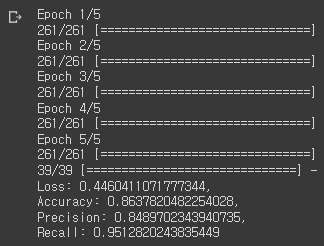

성능을 올려보고자 Dense block을, Conv block을, batch size(16 ~ 256까지)를, data augment 및 합성,(양옆 및 위아래), 클래스 가중 및 취소, 그림 해상도의 조절 180 ~ 720까지, epoch의 조절, 드롭아웃(제외~ 0.7), 등 데이터와 모델의 구조를 만지는데 까지는 만져본 것 같다  
아쉬운 점이 있다면, 해당 classification task에 대해서 inception v3이 좋은 효과를 거둔 것으로 나온 논문이 있었는데 해당 논문을 보고 구현하기에는 시간이 다소 모자랐으며, 파이토치에서는 nn.module에서 불러오는 모듈로 짜져 있었는데 케라스의 layer에서는 기능이 구현되어있는 것을 볼 수가 없었다  
여기에서 제일 핵심적으로 효과를 본것은 BATCH_SIZE였다  
고용량 램이었기 때문에 BATCH_SIZE를 계속 128 이상으로 가져갔었는데 에포크가 굉장히 빨리 지나갔고, early stop에 자주 걸렸었다, 그러나 BATCH_SIZE를 줄이고나서야 간신히 accuracy 86에 해당하는 점수를 얻을 수 있었고, 나머지는 사실상 코드 순정의 상태에서 진행을 했다  
좋은 정확도를 얻어서 다시 이 코드에서 하이퍼 파라미터를 수정해나갔지만, 다시 값들은 급속도로 나빠졌고, 대체적으로 0.62 어간에서 값이 수렴하였다  
지금에서야 드는 생각이지만 이미지를 오히려 줄여보고 모델도 경량화 했으면 어떨까 하는 생각이 들기도 한다. task에 맞는 적절한 데이터와 모델의 크기 비율을 맞추는 것에 대해서 다시한번 고민하게되었고, 병렬 연산을 돌리기 위해 Dataset을 만드는 연습을 많이 한 시간이었다  
Ai 모델링 기술이 좋아져야 하는데 다른 잡기술이 더 많이 늘어나는 기분이 든다..!